In [51]:
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
from tqdm import tqdm


# TO-DO 
Make heat maps insted of averages, so we see possible "bifurcation"

Make .py file with functions to declutter.

## Possibility of schools being connected
We now assign kids randmly to scholls, before assigning to households, such that a household with 2 kids attending 2 different institutions might cuase transmission between the schools

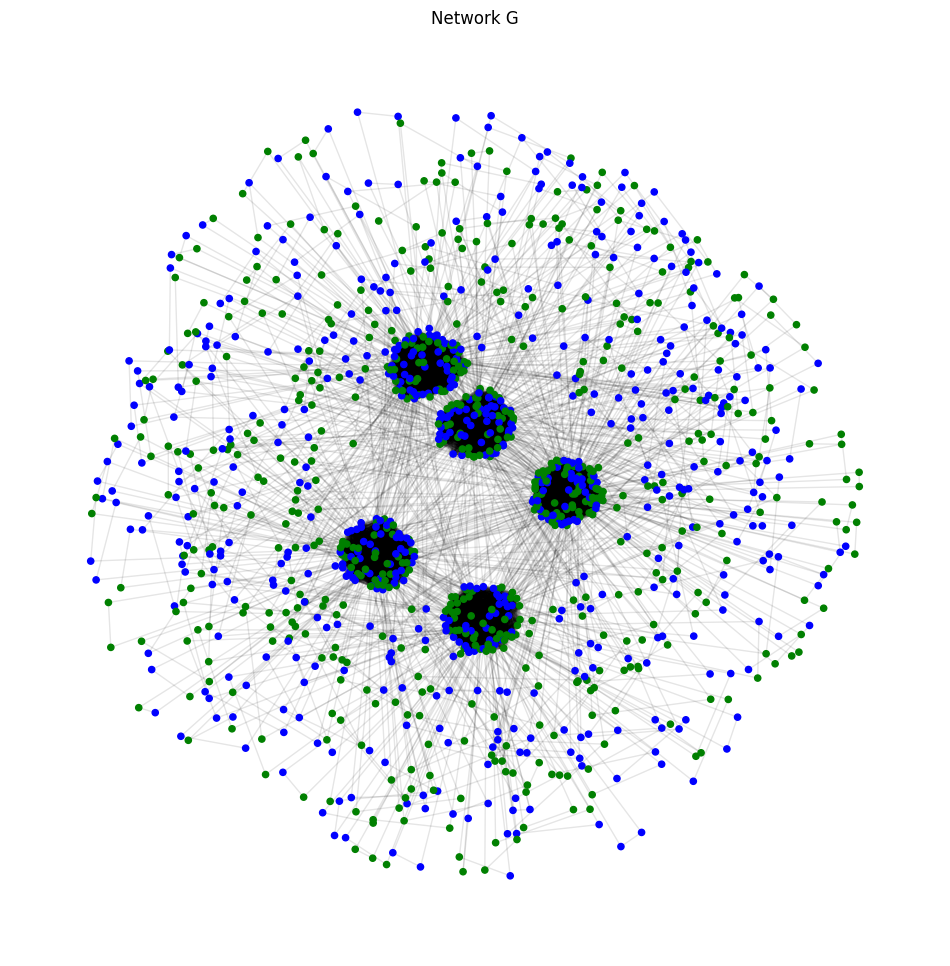

In [107]:
adults, kids = initialize_population()
kids = assign_kids_to_schools(kids)
households = form_households(adults, kids, 1)
G = build_network(adults, kids, households)

# Plotting the Entire Network again
plt.figure(figsize=(12, 12))

# Use a spring layout for positioning nodes
pos = nx.spring_layout(G, k=0.1, iterations=20)

# Get node colors based on status
node_colors = []
for node in G.nodes():
    status = G.nodes[node]['status']
    if status == 'S':
        node_colors.append('blue')
    elif status == 'I':
        node_colors.append('red')
    else:
        node_colors.append('green')

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20, node_color=node_colors)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Network G')
plt.axis('off')
plt.show()


 20%|██        | 1/5 [00:22<01:30, 22.54s/it]

p_inh: 0.00, Avg Outbreak Size: 2394.8, Avg Fraction Infected: 0.1607, Avg Num Clusters: 288.9, Avg Cluster Size: 2.00, Avg Giant Component Size: 220.46


 40%|████      | 2/5 [00:44<01:06, 22.12s/it]

p_inh: 0.25, Avg Outbreak Size: 2396.82, Avg Fraction Infected: 0.1600, Avg Num Clusters: 268.68, Avg Cluster Size: 2.14, Avg Giant Component Size: 229.80


 60%|██████    | 3/5 [01:13<00:50, 25.42s/it]

p_inh: 0.50, Avg Outbreak Size: 2425.8, Avg Fraction Infected: 0.2086, Avg Num Clusters: 246.14, Avg Cluster Size: 2.34, Avg Giant Component Size: 263.50


 80%|████████  | 4/5 [01:45<00:27, 27.98s/it]

p_inh: 0.75, Avg Outbreak Size: 2426.92, Avg Fraction Infected: 0.2165, Avg Num Clusters: 224.64, Avg Cluster Size: 2.58, Avg Giant Component Size: 310.32


100%|██████████| 5/5 [02:32<00:00, 30.45s/it]

p_inh: 1.00, Avg Outbreak Size: 2493.02, Avg Fraction Infected: 0.3263, Avg Num Clusters: 205.28, Avg Cluster Size: 2.81, Avg Giant Component Size: 334.74


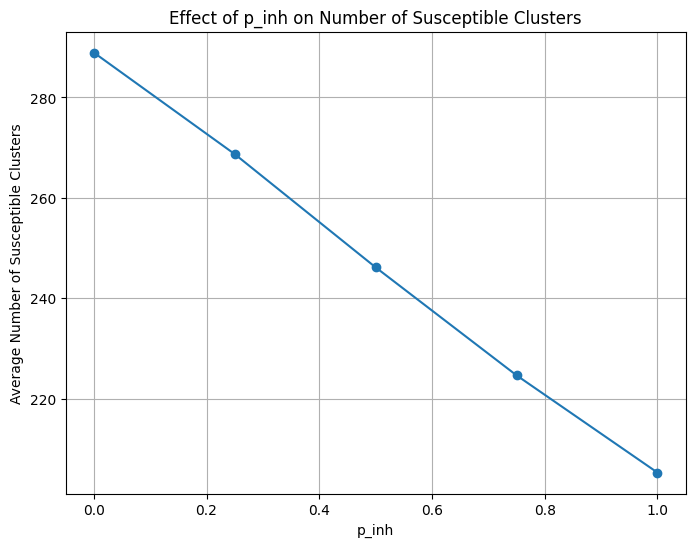

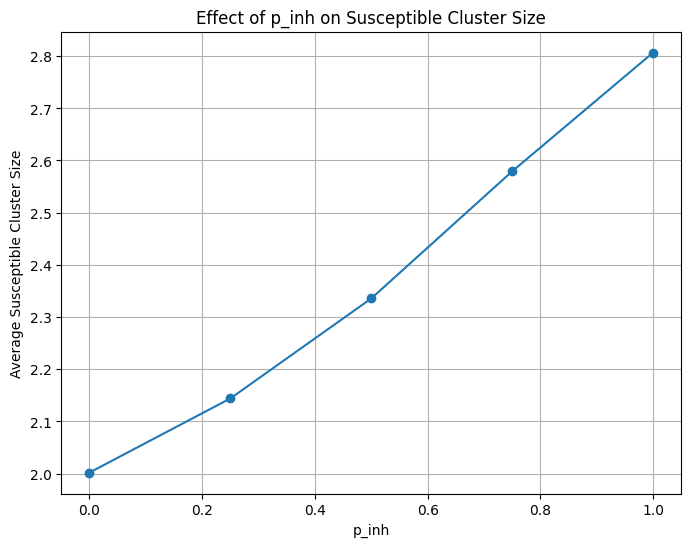

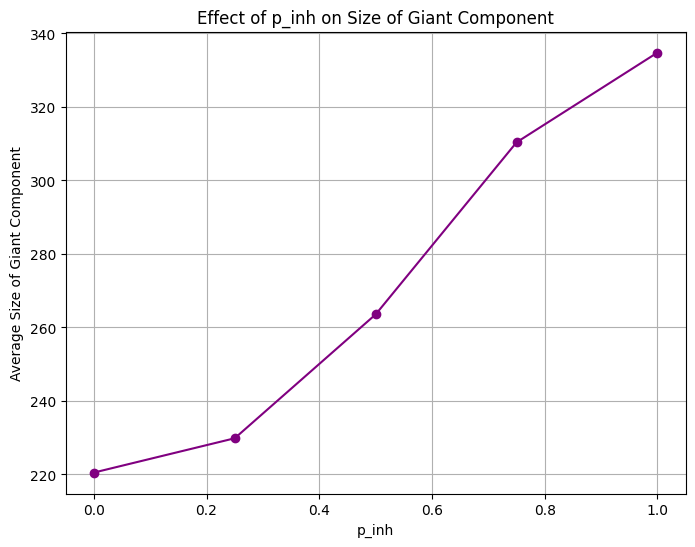

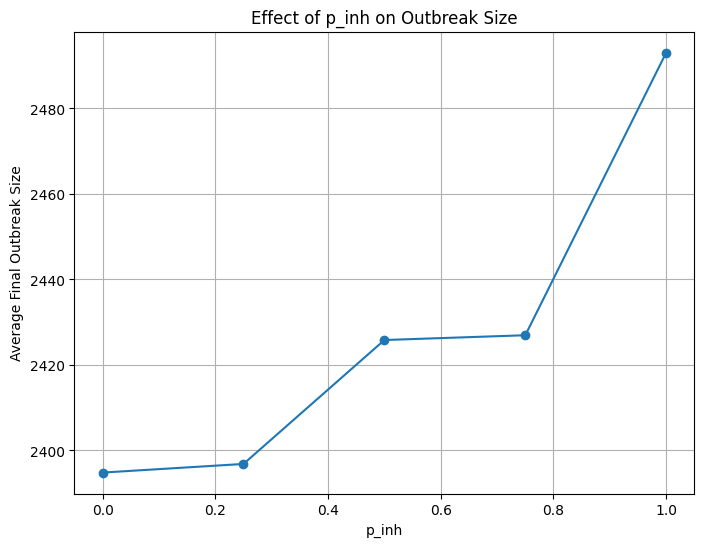

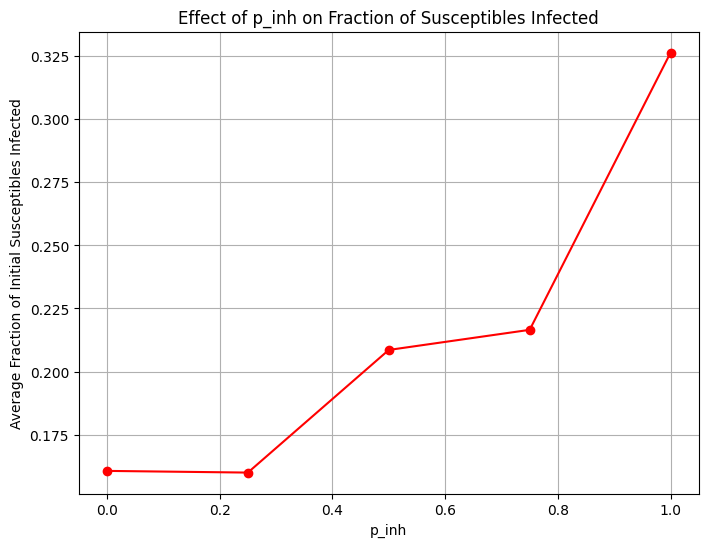

In [109]:
# Simulation parameters
Nh = 800           # Number of households
Ns = 10             # Number of schools
S_adult = 0.2       # Fraction of susceptible adults
S_kids = 0.2        # Fraction of susceptible kids
p_1 = 0.4           # Fraction of 1-kid households
beta = 1.6          # Infection rate
nu = beta/12           # Recovery rate
num_simulations = 50   # Number of simulations per p_inh


# Total number of adults and kids
num_adults = Nh * 2
num_1kid_houses = int(Nh * p_1)
num_2kid_houses = Nh - num_1kid_houses
num_kids = num_1kid_houses + num_2kid_houses * 2

print(f"Households:{Nh}, kids:{num_kids}, total pop; {num_kids + 2*Nh}, kids pr. school:{num_kids/Ns}")

def initialize_population():
    """Initialize the population of adults and kids with their susceptibility status."""
    # Adults
    adults = [{'id': f'adult_{i}', 'status': 'S' if random.random() < S_adult else 'R'} for i in range(num_adults)]
    # Kids
    kids = [{'id': f'kid_{i}', 'status': 'S' if random.random() < S_kids else 'R'} for i in range(num_kids)]
    return adults, kids

def assign_kids_to_schools(kids):
    """Assign each kid to a school randomly."""
    for kid in kids:
        kid['school'] = random.randint(0, Ns - 1)
    return kids

def form_households(adults, kids, p_inh):
    """Form households by pairing adults and assigning kids to households."""
    # Shuffle adults and form pairs
    random.shuffle(adults)
    adult_pairs = [adults[i:i+2] for i in range(0, num_adults, 2)]
    
    # Shuffle kids
    random.shuffle(kids)
    kid_index = 0
    households = []

    for i, pair in enumerate(adult_pairs):
        house = {'adults': pair, 'kids': []}
        # Determine the number of kids in the household
        num_house_kids = 1 if i < num_1kid_houses else 2

        for _ in range(num_house_kids):
            if kid_index >= num_kids:
                break  # No more kids to assign
            kid = kids[kid_index]

            # Check if we should assign the susceptible kid to this household based on p_inh
            if kid['status'] == 'S' and any(adult['status'] == 'S' for adult in pair):
                if random.random() < p_inh:
                    house['kids'].append(kid)
                    kid_index += 1
                else:
                    kid_index += 1  # Skip this kid
            else:
                house['kids'].append(kid)
                kid_index += 1

        households.append(house)

    # Assign any unassigned kids to households that need kids
    unassigned_kids = kids[kid_index:]
    if unassigned_kids:
        for kid in unassigned_kids:
            for house in households:
                expected_kids = 1 if len(house['kids']) == 0 else 2
                if len(house['kids']) < expected_kids:
                    house['kids'].append(kid)
                    break
    return households

def build_network(adults, kids, households):
    """Build the network with individuals as nodes and edges representing contacts."""
    G = nx.Graph()
    # Add nodes
    for adult in adults:
        G.add_node(adult['id'], status=adult['status'], type='adult')
    for kid in kids:
        G.add_node(kid['id'], status=kid['status'], type='kid', school=kid['school'])
    # Add household edges
    for house in households:
        # Adults
        if len(house['adults']) == 2:
            G.add_edge(house['adults'][0]['id'], house['adults'][1]['id'], relation='spouse')
        # Kids to parents
        for kid in house['kids']:
            for adult in house['adults']:
                G.add_edge(kid['id'], adult['id'], relation='parent')
        # Siblings
        if len(house['kids']) > 1:
            for i in range(len(house['kids'])):
                for j in range(i+1, len(house['kids'])):
                    G.add_edge(house['kids'][i]['id'], house['kids'][j]['id'], relation='sibling')
    # Add school edges
    schools = {i: [] for i in range(Ns)}
    for kid in kids:
        schools[kid['school']].append(kid['id'])
    for school_kids in schools.values():
        for i in range(len(school_kids)):
            for j in range(i+1, len(school_kids)):
                G.add_edge(school_kids[i], school_kids[j], relation='classmate')
    return G

def initialize_infection(G):
    """Infect a random susceptible individual to start the epidemic."""
    susceptible_nodes = [n for n, attr in G.nodes(data=True) if attr['status'] == 'S']
    if not susceptible_nodes:
        return None  # No susceptible individuals
    initial_infected = random.choice(susceptible_nodes)
    G.nodes[initial_infected]['status'] = 'I'
    return G

def gillespie_SIR(G, beta, nu):
    """Run the Gillespie algorithm for SIR dynamics."""
    time = 0
    times = [time]
    S_history = [sum(1 for n in G.nodes if G.nodes[n]['status'] == 'S')]
    I_history = [sum(1 for n in G.nodes if G.nodes[n]['status'] == 'I')]
    R_history = [sum(1 for n in G.nodes if G.nodes[n]['status'] == 'R')]
    
    while True:
        I_nodes = [n for n, attr in G.nodes(data=True) if attr['status'] == 'I']
        if not I_nodes:
            break  # No more infections

        infection_events = []
        for u in I_nodes:
            for v in G.neighbors(u):
                if G.nodes[v]['status'] == 'S':
                    infection_events.append((u, v))

        infection_rate = beta * len(infection_events)
        recovery_rate = nu * len(I_nodes)
        total_rate = infection_rate + recovery_rate

        if total_rate == 0:
            break  # No events can occur

        dt = np.random.exponential(1 / total_rate)
        time += dt

        if random.random() < (infection_rate / total_rate):
            # Infection event
            if infection_events:
                _, v = random.choice(infection_events)
                G.nodes[v]['status'] = 'I'
        else:
            # Recovery event
            u = random.choice(I_nodes)
            G.nodes[u]['status'] = 'R'

        # Record the number of S, I, R
        S_history.append(sum(1 for n in G.nodes if G.nodes[n]['status'] == 'S'))
        I_history.append(sum(1 for n in G.nodes if G.nodes[n]['status'] == 'I'))
        R_history.append(sum(1 for n in G.nodes if G.nodes[n]['status'] == 'R'))
        times.append(time)
    return times, S_history, I_history, R_history

def analyze_susceptible_clusters(G):
    """Analyze the clusters of susceptible individuals in the network."""
    # Step 1: Extract the subgraph of susceptible individuals
    susceptible_nodes = [n for n, attr in G.nodes(data=True) if attr['status'] == 'S']
    G_susceptible = G.subgraph(susceptible_nodes)
    
    # Step 2: Find connected components
    connected_components = list(nx.connected_components(G_susceptible))
    
    # Step 3: Calculate cluster sizes
    cluster_sizes = [len(component) for component in connected_components]
    
    # Step 4: Identify the size of the giant component
    if cluster_sizes:
        giant_component_size = max(cluster_sizes)
    else:
        giant_component_size = 0
    
    # Step 5: Report the results
    num_clusters = len(cluster_sizes)
    
    return num_clusters, cluster_sizes, giant_component_size

def run_simulation(p_inh):
    """Run the epidemic simulation for a given p_inh."""
    adults, kids = initialize_population()
    kids = assign_kids_to_schools(kids)
    households = form_households(adults, kids, p_inh)
    G = build_network(adults, kids, households)
    
    # Analyze susceptible clusters before the epidemic
    num_clusters, cluster_sizes, giant_component_size = analyze_susceptible_clusters(G)
    
    # Initialize infection
    G = initialize_infection(G)
    if G is None:
        return None, None, None, None, 0, 0, num_clusters, cluster_sizes, giant_component_size  # No susceptible individuals to infect

    # Record the initial number of susceptibles
    initial_susceptible = sum(1 for n in G.nodes if G.nodes[n]['status'] == 'S' or G.nodes[n]['status'] == 'I')
    
    times, S_history, I_history, R_history = gillespie_SIR(G, beta, nu)
    total_recovered = sum(1 for n in G.nodes if G.nodes[n]['status'] == 'R')

    # Calculate the fraction of initially susceptible individuals who became infected
    final_size_fraction = (total_recovered - R_history[0])/ initial_susceptible if initial_susceptible > 0 else 0

    return times, S_history, I_history, R_history, total_recovered, final_size_fraction, num_clusters, cluster_sizes, giant_component_size

# Main simulation loop
p_inh_values = np.linspace(0, 1, 5)  # 5 values from 0 to 1
final_outbreak_sizes = []
final_outbreak_fractions = []
cluster_numbers = []
average_cluster_sizes = []
average_giant_component_sizes = []

for p_inh in tqdm(p_inh_values):
    outbreak_sizes = []
    outbreak_size_fractions = []
    num_clusters_list = []
    cluster_size_lists = []
    giant_component_sizes = []
    
    for _ in range(num_simulations):
        result = run_simulation(p_inh)
        if result[0] is None:
            continue  # Skip if no susceptible individuals
        times, S_history, I_history, R_history, total_recovered, final_size_fraction, num_clusters, cluster_sizes, giant_component_size = result
        outbreak_sizes.append(total_recovered-R_history[0])
        outbreak_size_fractions.append(final_size_fraction)
        num_clusters_list.append(num_clusters)
        cluster_size_lists.extend(cluster_sizes)  # Collect all cluster sizes
        giant_component_sizes.append(giant_component_size)
    
    avg_outbreak_size = np.mean(outbreak_sizes)
    avg_outbreak_fraction = np.mean(outbreak_size_fractions)
    avg_num_clusters = np.mean(num_clusters_list)
    avg_cluster_size = np.mean(cluster_size_lists) if cluster_size_lists else 0
    avg_giant_component_size = np.mean(giant_component_sizes)
    
    final_outbreak_sizes.append(avg_outbreak_size)
    final_outbreak_fractions.append(avg_outbreak_fraction)
    cluster_numbers.append(avg_num_clusters)
    average_cluster_sizes.append(avg_cluster_size)
    average_giant_component_sizes.append(avg_giant_component_size)
    
    print(f"p_inh: {p_inh:.2f}, Avg Outbreak Size: {avg_outbreak_size}, "
          f"Avg Fraction Infected: {avg_outbreak_fraction:.4f}, "
          f"Avg Num Clusters: {avg_num_clusters}, "
          f"Avg Cluster Size: {avg_cluster_size:.2f}, "
          f"Avg Giant Component Size: {avg_giant_component_size:.2f}")

# Plot average number of clusters vs. p_inh
plt.figure(figsize=(8,6))
plt.plot(p_inh_values, cluster_numbers, marker='o')
plt.xlabel('p_inh')
plt.ylabel('Average Number of Susceptible Clusters')
plt.title('Effect of p_inh on Number of Susceptible Clusters')
plt.grid(True)
plt.show()

# Plot average cluster size vs. p_inh
plt.figure(figsize=(8,6))
plt.plot(p_inh_values, average_cluster_sizes, marker='o')
plt.xlabel('p_inh')
plt.ylabel('Average Susceptible Cluster Size')
plt.title('Effect of p_inh on Susceptible Cluster Size')
plt.grid(True)
plt.show()

# Plot average giant component size vs. p_inh
plt.figure(figsize=(8,6))
plt.plot(p_inh_values, average_giant_component_sizes, marker='o', color='purple')
plt.xlabel('p_inh')
plt.ylabel('Average Size of Giant Component')
plt.title('Effect of p_inh on Size of Giant Component')
plt.grid(True)
plt.show()

# Plot outbreak size vs. p_inh
plt.figure(figsize=(8, 6))
plt.plot(p_inh_values, final_outbreak_sizes, marker='o')
plt.xlabel('p_inh')
plt.ylabel('Average Final Outbreak Size')
plt.title('Effect of p_inh on Outbreak Size')
plt.grid(True)
plt.show()

# Plot outbreak fraction vs. p_inh
plt.figure(figsize=(8, 6))
plt.plot(p_inh_values, final_outbreak_fractions, marker='o', color='red')
plt.xlabel('p_inh')
plt.ylabel('Average Fraction of Initial Susceptibles Infected')
plt.title('Effect of p_inh on Fraction of Susceptibles Infected')
plt.grid(True)
plt.show()


In [111]:

print(f"Households:{Nh}, kids:{num_kids}, total pop; {num_kids + 2*Nh}, kids pr. school:{num_kids/Ns}, nr S: {S_adult*2*Nh + S_kids*num_kids}")

Households:800, kids:1280, total pop; 2880, kids pr. school:128.0, nr S: 576.0
